In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

In [2]:
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    
    return data

In [3]:
data = load_data('GOOGL')
df=data
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
0,2015-01-02,26.381865,26.693236,26.298664,26.533812,26480000
1,2015-01-05,25.879185,26.304145,25.793995,26.262296,41182000
2,2015-01-06,25.240501,25.966369,25.186198,25.930997,54456000
3,2015-01-07,25.166271,25.482126,25.091543,25.455225,46918000
4,2015-01-08,25.253954,25.283346,24.661600,24.984929,73054000


data = load_data('GOOGL')
df=data
df.head()

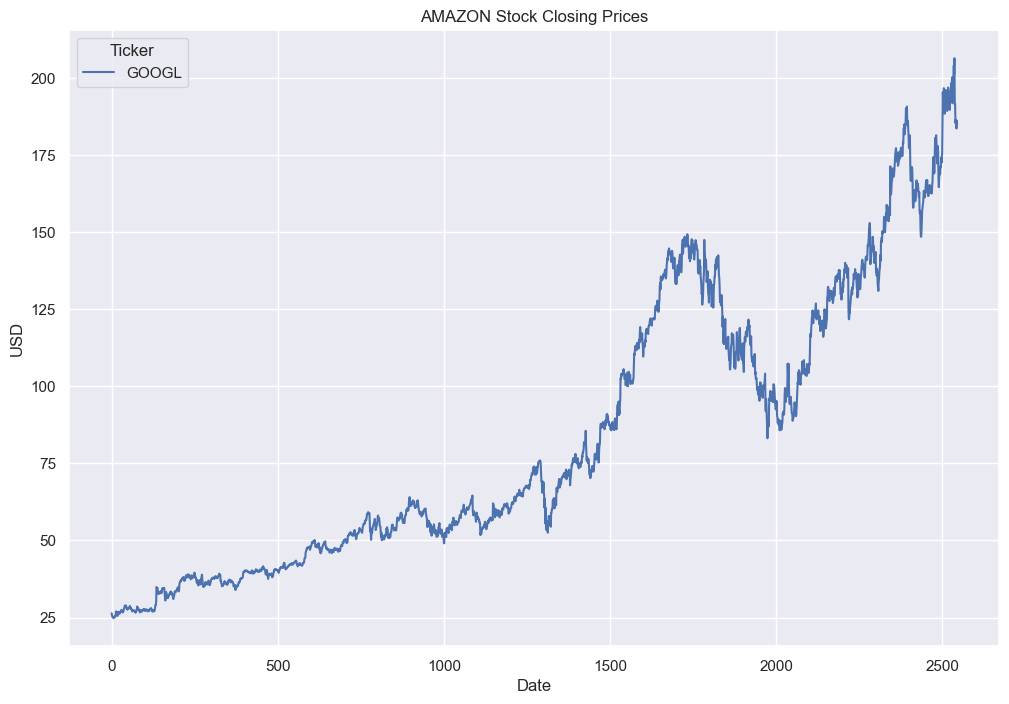

In [4]:
# Plot the closing price of AAPL
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df['Close'])
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('AMAZON Stock Closing Prices')
plt.show()

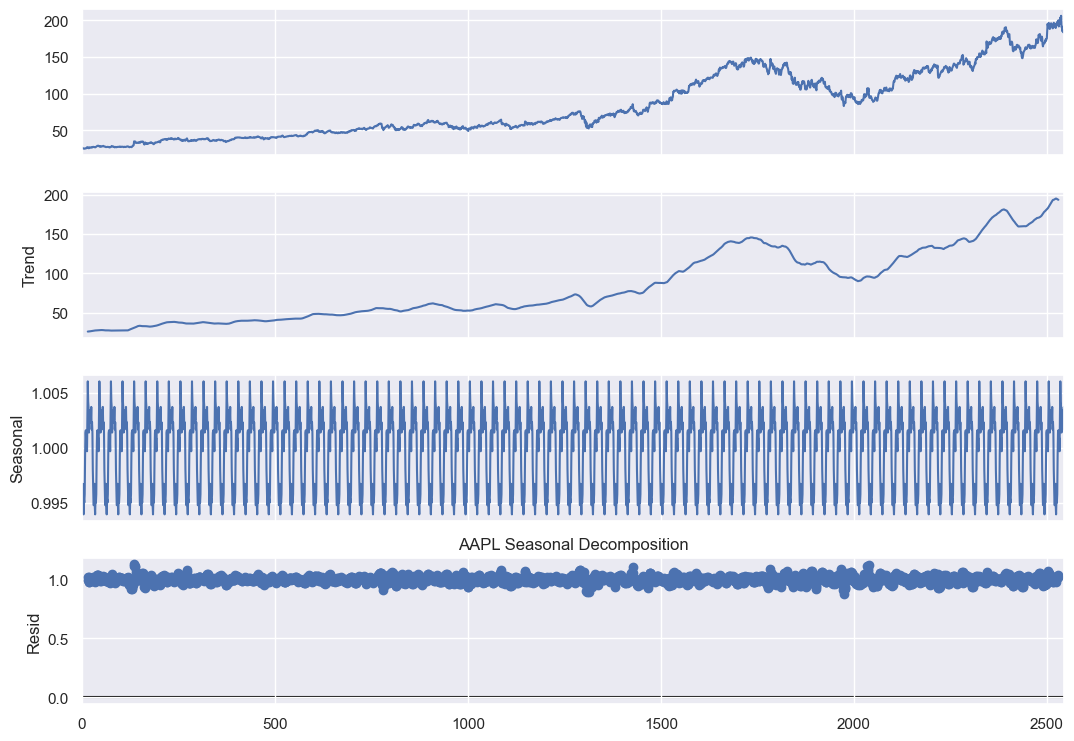

In [5]:
# Perform seasonal decomposition
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
fig = result.plot()
fig.set_size_inches(12, 8)
plt.title('AAPL Seasonal Decomposition')
plt.show()

In [6]:
# ADF Test for stationarity
print("ADF Test for AAPL:")
result = adfuller(df['Close'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print("Reject Null Hypothesis. Time Series is Stationary")
else:
    print("Failed to reject Null Hypothesis. Time Series is Non-Stationary")

ADF Test for AAPL:
ADF Statistic: 0.449115
p-value: 0.983242
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to reject Null Hypothesis. Time Series is Non-Stationary


In [7]:
# Normality Test
print("\nNormality Test for AAPL:")
stat, p = normaltest(df['Close'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed (reject H0)')


Normality Test for AAPL:
Statistics=305.096, p=0.000
Data is not normally distributed (reject H0)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8068\1782000390.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Statistics=%.3f, p=%.3f' % (stat, p))


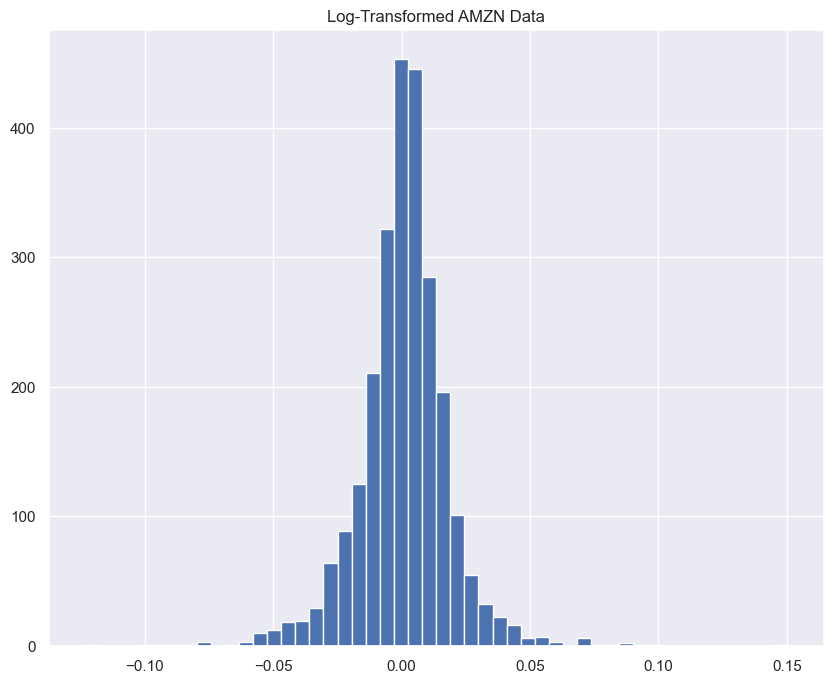

In [8]:
# Apply log transformation to make the data stationary
df_log = np.log(df['Close'] / df['Close'].shift(1))
df_log = df_log.dropna()  # Drop NaN values after transformation

# Plot the log-transformed data
df_log.hist(bins=50, figsize=(10, 8))
plt.title('Log-Transformed AMZN Data')
plt.show()

In [9]:
# ADF Test on log-transformed data
print("ADF Test for Log-Transformed AAPL Data:")
result = adfuller(df_log, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print("Reject Null Hypothesis. Time Series is Stationary")
else:
    print("Failed to reject Null Hypothesis. Time Series is Non-Stationary")

ADF Test for Log-Transformed AAPL Data:
ADF Statistic: -17.281940
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject Null Hypothesis. Time Series is Stationary


In [10]:
# Normality Test on log-transformed data
print("\nNormality Test for Log-Transformed AMZN Data:")
stat, p = normaltest(df_log)
print('Test Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed (reject H0)')


Normality Test for Log-Transformed AMZN Data:
Test Statistics=333.355, p=0.000
Data is not normally distributed (reject H0)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8068\2670124579.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Test Statistics=%.3f, p=%.3f' % (stat, p))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7230.519, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7234.034, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7230.194, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7230.091, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7233.627, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7227.881, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7229.628, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7229.653, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7231.883, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7232.089, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7228.103, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.479 seconds


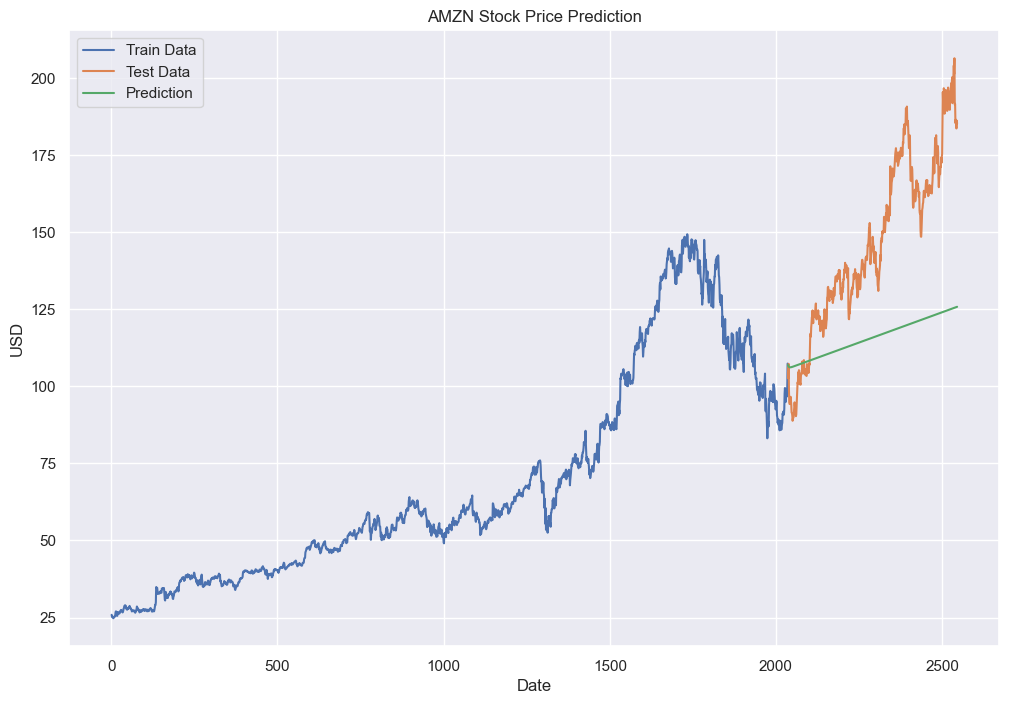

Best ARIMA Parameters for AMZN: (1, 1, 1)


In [11]:
# Split data into training and testing sets
train_data = df['Close'][1:int(len(df['Close']) * 0.8)]
test_data = df['Close'][int(len(df['Close']) * 0.8):]

# Auto-fit ARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_data)

# Forecast stock prices
forecast = model.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast, index=test_data.index)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data')
plt.plot(forecast, label='Prediction')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()

# Print the best ARIMA parameters
print(f"Best ARIMA Parameters for AMZN: {model.order}")

In [12]:
# Calculate error metrics (RMSE and MAE)
rmse = math.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 37.85494560798257
MAE: 32.159797587223466


In [13]:
mean_actual = np.mean(test_data)
accuracy = 100 * (1 - (rmse / mean_actual))
print(f"Custom Accuracy: {accuracy:.2f}%")

Custom Accuracy: 74.09%


In [17]:
print(f"ARIMA Order: {model.order}")  # e.g., (1, 1, 1)
d = model.order[1]  # Differencing order (d)

# Corrected code for in-sample predictions
arima_predictions = model.predict_in_sample(
    start=d,  # Start from index=d (e.g., 1 if d=1)
    end=len(train_data) - 1
)


# Align residuals with the original data
residuals = train_data[d:] - arima_predictions


# Create LSTM dataset with adjusted indices
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60
X_residuals, y_residuals = create_dataset(scaled_residuals, look_back)

ARIMA Order: (1, 1, 1)


In [26]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fit ARIMA model
model = auto_arima(train_data, trace=True, suppress_warnings=True)
model.fit(train_data)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7230.518, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7234.033, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7230.193, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7230.091, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7233.626, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7227.880, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7229.628, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7229.653, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7231.883, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7232.089, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7228.103, Time=0.21 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.943 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [27]:
# Get differencing order (d)
d = model.order[1]

# Get in-sample predictions (skip first d observations)
arima_predictions = model.predict_in_sample(start=d, end=len(train_data)-1)

# Calculate residuals (align with train_data[d:])
residuals = train_data[d:] - arima_predictions

In [28]:
# Scale residuals
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create LSTM dataset
look_back = 60
X_residuals, y_residuals = create_dataset(scaled_residuals, look_back)
X_residuals = np.reshape(X_residuals, (X_residuals.shape[0], X_residuals.shape[1], 1))

#reducing data size
X_residuals_small = X_residuals[::2]
y_residuals_small = y_residuals[::2]

C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [32]:
# Build and train LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(25, return_sequences=True, input_shape=(look_back, 1)))
lstm_model.add(LSTM(25, return_sequences=False))
lstm_model.add(Dense(10))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_residuals_small, y_residuals_small, epochs=1, batch_size=1000, verbose=1)


2070/2070 [==============================] - 626s 300ms/step - loss: nan


In [34]:
# Predict residuals and combine with ARIMA
lstm_predictions = lstm_model.predict(X_residuals_small)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Final predictions (adjust indices)
final_predictions = arima_predictions[look_back + 1:] + lstm_predictions.flatten()


64674/64674 [==============================] - 906s 14ms/step


ValueError: operands could not be broadcast together with shapes (1973,) (2069565,) 

NameError: name 'final_predictions' is not defined

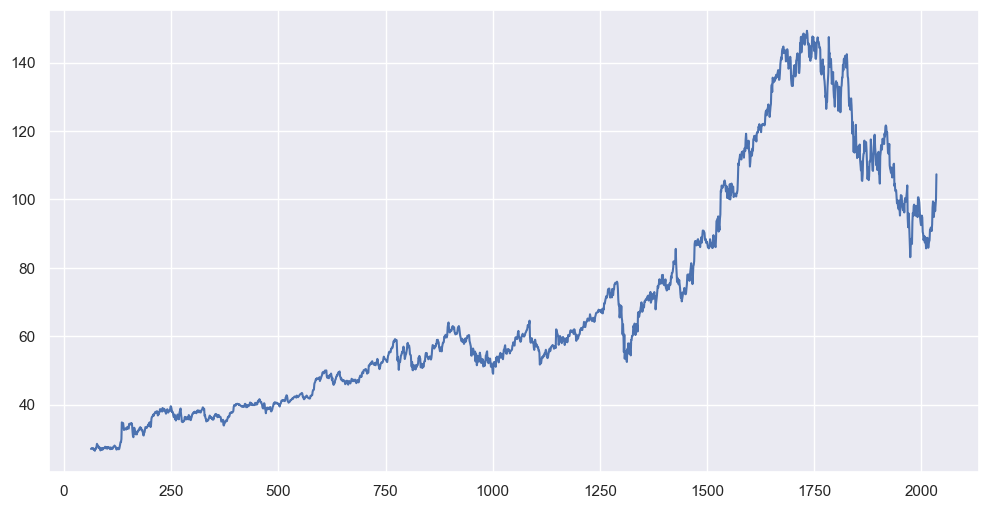

In [35]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_data[d + look_back + 1:], label='Actual Price')
plt.plot(final_predictions, label='Hybrid ARIMA-LSTM Prediction')
plt.title('Stock Price Forecast (ARIMA + LSTM)')
plt.legend()
plt.show()

In [14]:
# =====================================================
# STEP 1: Fit ARIMA and Extract Residuals (Non-Linear)
# =====================================================
from pmdarima import auto_arima

# Fit ARIMA model (use your existing code)
model = auto_arima(train_data, trace=True, suppress_warnings=True)
model.fit(train_data)

# Get in-sample predictions (for residuals)
arima_predictions = model.predict_in_sample(start=0, end=len(train_data)-1)

# Calculate residuals
residuals = train_data - arima_predictions



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7230.518, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7234.033, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7230.193, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7230.091, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7233.626, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7227.880, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7229.628, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7229.653, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7231.883, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7232.089, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7228.103, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.154 seconds


ValueError: In-sample predictions undefined for start=0 when d=1

In [ ]:

# STEP 2: Prepare Residuals for LSTM
# =====================================================
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale residuals
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create LSTM dataset (time steps = 60)
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60
X_residuals, y_residuals = create_dataset(scaled_residuals, look_back)

# Reshape for LSTM input [samples, timesteps, features]
X_residuals = np.reshape(X_residuals, (X_residuals.shape[0], X_residuals.shape[1], 1))

In [ ]:
# STEP 3: Build and Train LSTM Model
# =====================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# Compile and train
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_residuals, y_residuals, epochs=20, batch_size=32, verbose=1)


In [ ]:
STEP 4: Predict Residuals and Combine with ARIMA
# =====================================================
# Predict residuals using LSTM
lstm_predictions = lstm_model.predict(X_residuals)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Combine ARIMA + LSTM predictions
final_predictions = arima_predictions[look_back + 1:] + lstm_predictions.flatten()


In [ ]:
STEP 5: Plot Results
# =====================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data[look_back + 1:], label='Actual Price')
plt.plot(final_predictions, label='Hybrid ARIMA-LSTM Prediction')
plt.title('Stock Price Forecast (ARIMA + LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
STEP 6: Evaluate Model
# =====================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(train_data[look_back + 1:], final_predictions))
mae = mean_absolute_error(train_data[look_back + 1:], final_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")